# Introduction
***

Amazon SageMaker NTM (Neural Topic Model) is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. NTM is most commonly used to discover a user-specified number of topics shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified up front, and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics.

In this notebook we will use the Amazon SageMaker NTM algorithm to train a model on some example synthetic data. We will then use this model to classify (perform inference on) the data. The main goals of this notebook are to,

* create an AWS SageMaker training job on a data set to produce a NTM model,
* use the model to perform inference with an Amazon SageMaker endpoint.

In [1]:
import os
import sagemaker
import boto3
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

role = get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-228889150161


## Training

Once the data is preprocessed and available in a recommended format the next step is to train our model on the data. There are number of parameters required by the NTM algorithm to configure the model and define the computational environment in which training will take place. The first of these is to point to a container image which holds the algorithms training and hosting code.

In [2]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/ntm:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/ntm:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/ntm:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/ntm:latest'}

An NTM model uses the following hyperparameters:

- **num_topics** - The number of topics or categories in the NTM model. 
- **feature_dim** - The size of the "vocabulary". In this case, this has been set to 1000 by the nytimes pyspark data prep.

In addition to these NTM model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role.

> Note: Try adjusting the mini_batch_size if running on a GPU. 

In [4]:
num_topics=20
vocabulary_size=5000
output = 's3://{}/data/nytimes-model/sagemaker-ntm'.format(sagemaker_session.default_bucket())

ntm = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p3.2xlarge',
                                    output_path=output,
                                    sagemaker_session=sagemaker_session)

ntm.set_hyperparameters(num_topics=num_topics,
                        feature_dim=vocabulary_size,
                        mini_batch_size=1024,
                        batch_norm=True,
                        epochs=100)

We'll train against the bag-of-words extracted from the NY Times comments.

In [5]:
import boto3
s3_client = boto3.client('s3')
objects = s3_client.list_objects(Bucket=bucket, Prefix='data/nyt-record-io/training.rec')
training_key = objects['Contents'][0]['Key']
training_input = 's3://{}/{}'.format(bucket, training_key)

In [6]:
ntm.fit({'train': training_input})

INFO:sagemaker:Creating training-job with name: ntm-2018-06-04-18-18-43-252


....................
Docker entrypoint called with argument(s): train
[06/04/2018 18:21:50 INFO 140428157937472] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'tolerance': u'0.001', u'batch_norm': u'false'}
[06/04/2018 18:21:50 INFO 140428157937472] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'epochs': u'100', u'feature_dim': u'5000', u'mini_batch_size': u'1024', u'num_topics': u'20', u'batch_norm': u'True'}
[06/04/2018 18:21:50 INFO 140428157937472] Final configuration: {u'optimiz

[06/04/2018 18:22:21 INFO 140428157937472] # Finished training epoch 4 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:22:21 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:22:21 INFO 140428157937472] Loss (name: value) total: 7.6456688544
[06/04/2018 18:22:21 INFO 140428157937472] Loss (name: value) kld: 0.064502665265
[06/04/2018 18:22:21 INFO 140428157937472] Loss (name: value) recons: 7.581166227
[06/04/2018 18:22:21 INFO 140428157937472] Loss (name: value) logppx: 7.6456688544
[06/04/2018 18:22:21 INFO 140428157937472] #quality_metric: host=algo-1, epoch=4, train total_loss <loss>=7.6456688544
[06/04/2018 18:22:21 INFO 140428157937472] patience losses:[7.7835778643277065, 7.7017566532142894, 7.672369407228202] min patience loss:7.67236940723 current loss:7.6456688544 absolute loss difference:0.02670055283
[06/04/2018 18:22:21 INFO 140428157937472] #progress_metric: host=algo-1, completed 4 % of epochs
#metrics {"Metrics": {"Max Batches Seen Betwee

[06/04/2018 18:22:44 INFO 140428157937472] # Finished training epoch 8 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:22:44 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:22:44 INFO 140428157937472] Loss (name: value) total: 7.58575571076
[06/04/2018 18:22:44 INFO 140428157937472] Loss (name: value) kld: 0.121809427372
[06/04/2018 18:22:44 INFO 140428157937472] Loss (name: value) recons: 7.46394628853
[06/04/2018 18:22:44 INFO 140428157937472] Loss (name: value) logppx: 7.58575571076
[06/04/2018 18:22:44 INFO 140428157937472] #quality_metric: host=algo-1, epoch=8, train total_loss <loss>=7.58575571076
[06/04/2018 18:22:44 INFO 140428157937472] patience losses:[7.625178804082319, 7.6091585947462352, 7.5961620433271424] min patience loss:7.59616204333 current loss:7.58575571076 absolute loss difference:0.0104063325677
[06/04/2018 18:22:44 INFO 140428157937472] #progress_metric: host=algo-1, completed 8 % of epochs
#metrics {"Metrics": {"Max Batches See

[06/04/2018 18:23:11 INFO 140428157937472] # Finished training epoch 13 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:23:11 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:23:11 INFO 140428157937472] Loss (name: value) total: 7.55324552128
[06/04/2018 18:23:11 INFO 140428157937472] Loss (name: value) kld: 0.157767172256
[06/04/2018 18:23:11 INFO 140428157937472] Loss (name: value) recons: 7.39547837667
[06/04/2018 18:23:11 INFO 140428157937472] Loss (name: value) logppx: 7.55324552128
[06/04/2018 18:23:11 INFO 140428157937472] #quality_metric: host=algo-1, epoch=13, train total_loss <loss>=7.55324552128
[06/04/2018 18:23:11 INFO 140428157937472] patience losses:[7.5693147049462501, 7.5629388039762322, 7.5580417100063038] min patience loss:7.55804171001 current loss:7.55324552128 absolute loss difference:0.00479618872493
[06/04/2018 18:23:11 INFO 140428157937472] #progress_metric: host=algo-1, completed 13 % of epochs
#metrics {"Metrics": {"Max Batche

[06/04/2018 18:23:33 INFO 140428157937472] # Finished training epoch 17 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:23:33 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:23:33 INFO 140428157937472] Loss (name: value) total: 7.53643400413
[06/04/2018 18:23:33 INFO 140428157937472] Loss (name: value) kld: 0.178499530046
[06/04/2018 18:23:33 INFO 140428157937472] Loss (name: value) recons: 7.35793445204
[06/04/2018 18:23:33 INFO 140428157937472] Loss (name: value) logppx: 7.53643400413
[06/04/2018 18:23:33 INFO 140428157937472] #quality_metric: host=algo-1, epoch=17, train total_loss <loss>=7.53643400413
[06/04/2018 18:23:33 INFO 140428157937472] patience losses:[7.5483319715034867, 7.5448447746678822, 7.5400480012263147] min patience loss:7.54004800123 current loss:7.53643400413 absolute loss difference:0.00361399709686
[06/04/2018 18:23:33 INFO 140428157937472] #progress_metric: host=algo-1, completed 17 % of epochs
#metrics {"Metrics": {"Max Batche

[06/04/2018 18:23:55 INFO 140428157937472] # Finished training epoch 21 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:23:55 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:23:55 INFO 140428157937472] Loss (name: value) total: 7.52285908027
[06/04/2018 18:23:55 INFO 140428157937472] Loss (name: value) kld: 0.194295857656
[06/04/2018 18:23:55 INFO 140428157937472] Loss (name: value) recons: 7.32856322763
[06/04/2018 18:23:55 INFO 140428157937472] Loss (name: value) logppx: 7.52285908027
[06/04/2018 18:23:55 INFO 140428157937472] #quality_metric: host=algo-1, epoch=21, train total_loss <loss>=7.52285908027
[06/04/2018 18:23:55 INFO 140428157937472] patience losses:[7.5323660693877983, 7.5291363429432074, 7.5255870769831761] min patience loss:7.52558707698 current loss:7.52285908027 absolute loss difference:0.00272799671189
[06/04/2018 18:23:55 INFO 140428157937472] #progress_metric: host=algo-1, completed 21 % of epochs
#metrics {"Metrics": {"Max Batche

[06/04/2018 18:24:22 INFO 140428157937472] # Finished training epoch 26 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:24:22 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:24:22 INFO 140428157937472] Loss (name: value) total: 7.51010426362
[06/04/2018 18:24:22 INFO 140428157937472] Loss (name: value) kld: 0.207107536741
[06/04/2018 18:24:22 INFO 140428157937472] Loss (name: value) recons: 7.30299667731
[06/04/2018 18:24:22 INFO 140428157937472] Loss (name: value) logppx: 7.51010426362
[06/04/2018 18:24:22 INFO 140428157937472] #quality_metric: host=algo-1, epoch=26, train total_loss <loss>=7.51010426362
[06/04/2018 18:24:22 INFO 140428157937472] patience losses:[7.5160537485248788, 7.5146990103169911, 7.5127206498926338] min patience loss:7.51272064989 current loss:7.51010426362 absolute loss difference:0.00261638627565
[06/04/2018 18:24:22 INFO 140428157937472] #progress_metric: host=algo-1, completed 26 % of epochs
#metrics {"Metrics": {"Max Batche

[06/04/2018 18:24:44 INFO 140428157937472] # Finished training epoch 30 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:24:44 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:24:44 INFO 140428157937472] Loss (name: value) total: 7.50183059066
[06/04/2018 18:24:44 INFO 140428157937472] Loss (name: value) kld: 0.214590525947
[06/04/2018 18:24:44 INFO 140428157937472] Loss (name: value) recons: 7.28724006656
[06/04/2018 18:24:44 INFO 140428157937472] Loss (name: value) logppx: 7.50183059066
[06/04/2018 18:24:44 INFO 140428157937472] #quality_metric: host=algo-1, epoch=30, train total_loss <loss>=7.50183059066
[06/04/2018 18:24:44 INFO 140428157937472] patience losses:[7.5083601597912057, 7.5050855392266893, 7.5040246386173344] min patience loss:7.50402463862 current loss:7.50183059066 absolute loss difference:0.00219404795938
[06/04/2018 18:24:44 INFO 140428157937472] #progress_metric: host=algo-1, completed 30 % of epochs
#metrics {"Metrics": {"Max Batche

[06/04/2018 18:25:06 INFO 140428157937472] # Finished training epoch 34 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:25:06 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:25:06 INFO 140428157937472] Loss (name: value) total: 7.4967211544
[06/04/2018 18:25:06 INFO 140428157937472] Loss (name: value) kld: 0.221572171558
[06/04/2018 18:25:06 INFO 140428157937472] Loss (name: value) recons: 7.27514894516
[06/04/2018 18:25:06 INFO 140428157937472] Loss (name: value) logppx: 7.4967211544
[06/04/2018 18:25:06 INFO 140428157937472] #quality_metric: host=algo-1, epoch=34, train total_loss <loss>=7.4967211544
[06/04/2018 18:25:06 INFO 140428157937472] patience losses:[7.5014205062684933, 7.4993932705280208, 7.4980251577274855] min patience loss:7.49802515773 current loss:7.4967211544 absolute loss difference:0.00130400332537
[06/04/2018 18:25:06 INFO 140428157937472] #progress_metric: host=algo-1, completed 34 % of epochs
#metrics {"Metrics": {"Max Batches Se

[06/04/2018 18:25:34 INFO 140428157937472] # Finished training epoch 39 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:25:34 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:25:34 INFO 140428157937472] Loss (name: value) total: 7.49001414569
[06/04/2018 18:25:34 INFO 140428157937472] Loss (name: value) kld: 0.228315945314
[06/04/2018 18:25:34 INFO 140428157937472] Loss (name: value) recons: 7.26169823984
[06/04/2018 18:25:34 INFO 140428157937472] Loss (name: value) logppx: 7.49001414569
[06/04/2018 18:25:34 INFO 140428157937472] #quality_metric: host=algo-1, epoch=39, train total_loss <loss>=7.49001414569
[06/04/2018 18:25:34 INFO 140428157937472] patience losses:[7.4937141340626177, 7.4930639375339858, 7.4915555124440472] min patience loss:7.49155551244 current loss:7.49001414569 absolute loss difference:0.00154136675449
[06/04/2018 18:25:34 INFO 140428157937472] #progress_metric: host=algo-1, completed 39 % of epochs
#metrics {"Metrics": {"Max Batche

[06/04/2018 18:25:56 INFO 140428157937472] # Finished training epoch 43 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:25:56 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:25:56 INFO 140428157937472] Loss (name: value) total: 7.48577635938
[06/04/2018 18:25:56 INFO 140428157937472] Loss (name: value) kld: 0.232756562038
[06/04/2018 18:25:56 INFO 140428157937472] Loss (name: value) recons: 7.25301979273
[06/04/2018 18:25:56 INFO 140428157937472] Loss (name: value) logppx: 7.48577635938
[06/04/2018 18:25:56 INFO 140428157937472] #quality_metric: host=algo-1, epoch=43, train total_loss <loss>=7.48577635938
[06/04/2018 18:25:56 INFO 140428157937472] patience losses:[7.4893793192776767, 7.4887317788502399, 7.486798934700075] min patience loss:7.4867989347 current loss:7.48577635938 absolute loss difference:0.00102257531536
[06/04/2018 18:25:56 INFO 140428157937472] #progress_metric: host=algo-1, completed 43 % of epochs
#metrics {"Metrics": {"Max Batches 

[06/04/2018 18:26:18 INFO 140428157937472] # Finished training epoch 47 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:26:18 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:26:18 INFO 140428157937472] Loss (name: value) total: 7.48239091802
[06/04/2018 18:26:18 INFO 140428157937472] Loss (name: value) kld: 0.236244338141
[06/04/2018 18:26:18 INFO 140428157937472] Loss (name: value) recons: 7.24614658656
[06/04/2018 18:26:18 INFO 140428157937472] Loss (name: value) logppx: 7.48239091802
[06/04/2018 18:26:18 INFO 140428157937472] #quality_metric: host=algo-1, epoch=47, train total_loss <loss>=7.48239091802
[06/04/2018 18:26:18 INFO 140428157937472] patience losses:[7.4852592270236373, 7.4848229968843381, 7.4826088286628405] min patience loss:7.48260882866 current loss:7.48239091802 absolute loss difference:0.000217910640496
[06/04/2018 18:26:18 INFO 140428157937472] Bad epoch: loss has not improved (enough). Bad count:1
[06/04/2018 18:26:18 INFO 1404281

[06/04/2018 18:26:45 INFO 140428157937472] # Finished training epoch 52 on 246918 examples from 242 batches, each of size 1024.
[06/04/2018 18:26:45 INFO 140428157937472] Metrics for Training:
[06/04/2018 18:26:45 INFO 140428157937472] Loss (name: value) total: 7.47845648537
[06/04/2018 18:26:45 INFO 140428157937472] Loss (name: value) kld: 0.241567203483
[06/04/2018 18:26:45 INFO 140428157937472] Loss (name: value) recons: 7.23688926332
[06/04/2018 18:26:45 INFO 140428157937472] Loss (name: value) logppx: 7.47845648537
[06/04/2018 18:26:45 INFO 140428157937472] #quality_metric: host=algo-1, epoch=52, train total_loss <loss>=7.47845648537
[06/04/2018 18:26:45 INFO 140428157937472] patience losses:[7.4804912687333163, 7.4795890413532575, 7.4790471999113226] min patience loss:7.47904719991 current loss:7.47845648537 absolute loss difference:0.000590714541349
[06/04/2018 18:26:45 INFO 140428157937472] Bad epoch: loss has not improved (enough). Bad count:4
[06/04/2018 18:26:45 INFO 1404281

## Inference

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document or comment.

This is simplified by the deploy function provided by the Amazon SageMaker Python SDK.

In [ ]:
ntm_predictor = ntm.deploy(initial_instance_count=1,
                           instance_type='ml.c5.large',
                          endpoint_name='ntm-nyt')

INFO:sagemaker:Creating model with name: ntm-2018-06-04-18-31-37-242
INFO:sagemaker:Creating endpoint with name ntm-nyt


----------------------------------------------------------------

## Model Exploration 

This next section is based on ["An Introduction to SageMaker Neural Topic Model"](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/ntm_20newsgroups_topic_modeling/ntm_20newsgroups_topic_model.ipynb).  While this section isn't required for model deployment, it does offer some explaination the model's generated topics.

In [7]:
!pip install mxnet 
import mxnet as mx

    100% |████████████████████████████████| 26.1MB 47kB/s  eta 0:00:01
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
model_path = os.path.join('data/nytimes-model/sagemaker-ntm', ntm._current_job_name, 'output/model.tar.gz')
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')
!tar -xzvf 'downloaded_model.tar.gz'
!unzip -o model_algo-1

model_algo-1
Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [9]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

In [10]:
!pip install wordcloud
import wordcloud as wc

    100% |████████████████████████████████| 174kB 5.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for wordcloud ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3e/40/7c/d768cb5022ec6aa5611728339886bc1e9f0b629547f39237fd
Successfully built wordcloud
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import boto3
import json

s3 = boto3.resource('s3')
obj = s3.Object('sagemaker-us-east-1-228889150161','data/nyt-features/vocab.json')
obj.download_file('vocab.json')

def load_vocab():
    with open('vocab.json', 'r') as json_file:
        return json.load(json_file)

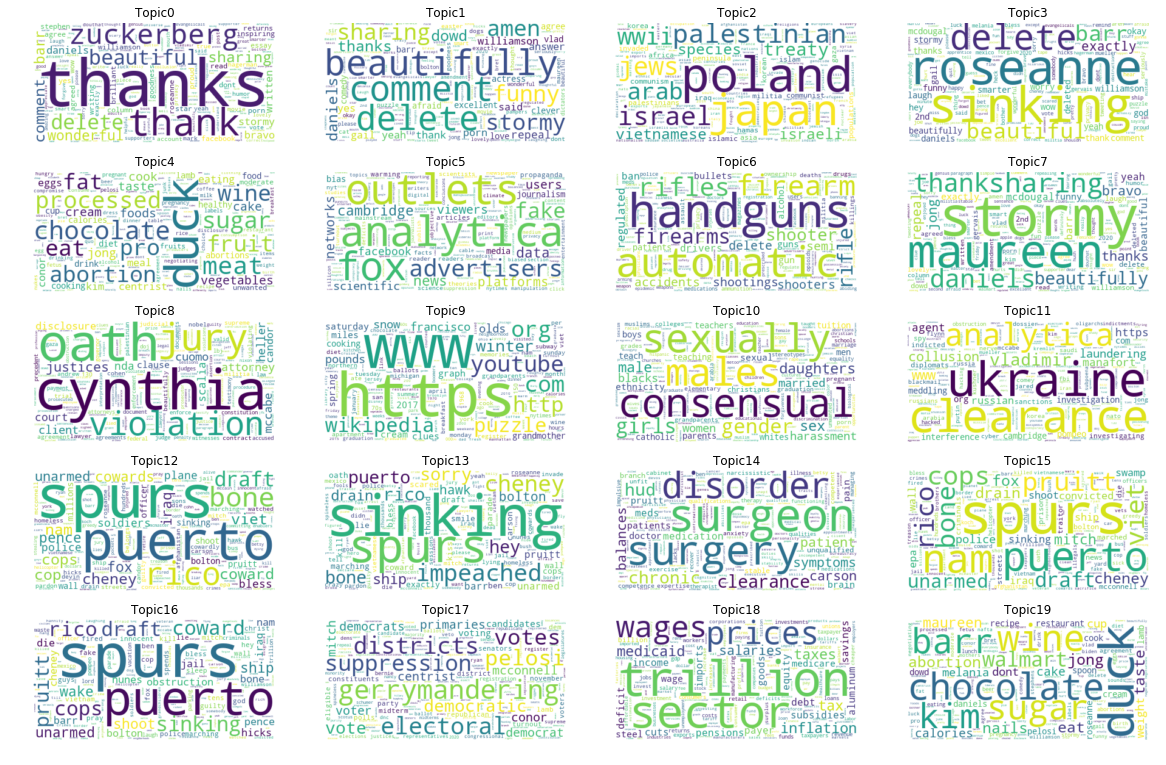

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

word_to_id = load_vocab()

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1
